In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

from keras.models import Model
from keras.layers import *
from keras import backend as K
from tensorflow.keras.utils import get_file
from keras.regularizers import l2


# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.16.1


In [ ]:
!ls /kaggle/input

In [2]:
data = np.load("/kaggle/input/cleaneddataset/cleanedDataset.npz")
augdata=np.load("/kaggle/input/augmented-relabeled-rocks/augmented_dataset_only_geom_2.npz")

X_train = augdata["images"]
y_train = augdata["masks"]

X_test = data["X_test"]
X_true = data["X_train"]
y_true = data["y_train"]


print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (14835, 64, 128, 1)
Training y shape: (14835, 64, 128)
Test X shape: (10022, 64, 128, 1)


In [5]:
# Split data into train_val and test sets
X_test1, X_val, y_test1, y_val = train_test_split(
    X_true,
    y_true,
    random_state=seed,
    test_size=0.5,
)


# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test1 shape: {X_test1.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (14835, 64, 128, 1), y_train shape: (14835, 64, 128)
X_val shape: (1253, 64, 128, 1), y_val shape: (1253, 64, 128)
X_test1 shape: (1252, 64, 128, 1)
X_test shape: (10022, 64, 128, 1)


In [6]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [7]:
# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 20

# Set maximum number of training epochs
EPOCHS = 200

num_classes = 5

In [12]:
''' USA QUESTO '''

from tensorflow.keras.layers import *

#------------------------------------------------------------------ bottleneck
def se_block(inputs, reduction_ratio=16):
    filters = inputs.shape[-1]
    se = GlobalAveragePooling2D()(inputs)
    se = Dense(filters // reduction_ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Multiply()([inputs, se])
    return se


#------------------------------------------------------------------------------------------------------------------------------



def inception_block(x, filters, kernel_size=3, padding='same', downsample=True, activation='relu', stack=2):
    # Define the original Inception block (2014) structure without Batch Normalisation
    for s in range(stack):
        # 1x1 convolutional path
        conv1 = tfkl.Conv2D(filters // 4, 1, padding=padding)(x)
        conv1 = tfkl.Activation(activation)(conv1)

        # 3x3 convolutional path with initial reduction
        conv3_reduce = tfkl.Conv2D(filters // 8, 1, padding=padding)(x)
        conv3_reduce = tfkl.Activation(activation)(conv3_reduce)
        conv3 = tfkl.Conv2D(filters // 4, 3, padding=padding)(conv3_reduce)
        conv3 = tfkl.Activation(activation)(conv3)

        # 5x5 convolutional path with initial reduction
        conv5_reduce = tfkl.Conv2D(filters // 12, 1, padding=padding)(x)
        conv5_reduce = tfkl.Activation(activation)(conv5_reduce)
        conv5 = tfkl.Conv2D(filters // 4, 5, padding=padding)(conv5_reduce)
        conv5 = tfkl.Activation(activation)(conv5)

        # Pooling path with projection
        pool = tfkl.MaxPooling2D(3, strides=1, padding=padding)(x)
        pool_proj = tfkl.Conv2D(filters // 4, 1, padding=padding)(pool)
        pool_proj = tfkl.Activation(activation)(pool_proj)

        # Concatenate paths
        x = tfkl.Concatenate()([conv1, conv3, conv5, pool_proj])

    # Apply downsampling if specified
    if downsample:
        x = tfkl.MaxPooling2D(2)(x)
    return x



#--------------------------------------------------------#--------------------------------------------------------

def encoder_block(inputs, filters, pool_size=(2, 2), kernel_reg=1e-4, kernel_size=3, padding='same', downsample=True, activation='relu', stack=2, name='encoder'):
    """
    Encoder block with the integration of Inception block.
    """
    # First Convolutional Layer
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer='he_normal', kernel_regularizer=l2(kernel_reg))(inputs)
    conv = BatchNormalization()(conv)
    conv = ReLU()(conv)
    
    # Inception Block
    inception = inception_block(conv, filters, kernel_size=kernel_size, padding=padding, downsample=False, activation=activation, stack=stack)


    conv = se_block(inception)
    
    # Second Convolutional Layer
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer='he_normal', kernel_regularizer=l2(kernel_reg))(conv)
    conv = BatchNormalization()(conv)
    conv = ReLU()(conv)

    

    # Spatial Dropout for regularization
    conv = SpatialDropout2D(0.3)(conv)
    
    # Pooling Layer for downsampling
    pool = MaxPooling2D(pool_size=pool_size)(conv)
    return conv, pool

#-------------------------------------------------------------------------------- Decoder block
def decoder_block(inputs, skip_connection, filters, pool_size=(2, 2), kernel_reg=1e-4, kernel_size=3, padding='same', downsample=True, activation='relu', stack=2):
    # Apply mini ASPP and inception block
    inception = inception_block(skip_connection, filters, kernel_size=kernel_size, padding=padding, downsample=False, activation=activation, stack=stack)

    # Upsample `inputs`
    up = Conv2DTranspose(filters, 2, strides=(2, 2), activation='relu', padding='same')(inception)

    # Ensure `inputs` is resized to match `up`
    if inputs.shape[1] != up.shape[1] or inputs.shape[2] != up.shape[2]:
        inputs_resized = UpSampling2D(size=(up.shape[1] // inputs.shape[1], up.shape[2] // inputs.shape[2]))(inputs)
    else:
        inputs_resized = inputs

    # Concatenate
    merge = concatenate([inputs_resized, up], axis=3)


    # Squeeze-and-Excitation Block
    se = se_block(merge)

    # Additional convolutions
    conv = Conv2D(filters, 3, activation='relu', padding='same')(se)
    conv = BatchNormalization()(conv)

    return conv
#------------------------------------------------------------------------------------------------------------------------------------------------



def unet(input_size=(64,128,1), num_classes=5, learning_rate=LEARNING_RATE, filters=32, pool_size=(2, 2), kernel_reg=1e-4, kernel_size=3, padding='same', downsample=True, activation='relu', stack=2,):
    
    inputs = Input(shape=input_size, name='input_layer')

    # Encoder
    conv0, pool0 = encoder_block(inputs, filters)
    conv1, pool1 = encoder_block(pool0, filters*2)
    conv2, pool2 = encoder_block(pool1, filters*4)
    conv3, pool3 = encoder_block(pool2, filters*8)


    
    # Bottleneck
    conv4 = inception_block(pool3, filters*16, kernel_size=kernel_size, padding=padding, downsample=False, activation=activation, stack=stack)
    shortcut = Conv2D(filters*16, 1, padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Add()([conv4, shortcut])  # Residual connection
    conv4 = se_block(conv4)
    drop4 = Dropout(0.3)(conv4)


    
    # Decoder
    conv5 = decoder_block(drop4, conv3, filters*8)
    conv6 = decoder_block(conv5, conv2, filters*4)
    conv7 = decoder_block(conv6, conv1, filters*2)
    conv8 = decoder_block(conv7, conv0, filters)
    pool = MaxPooling2D(pool_size=(2,2))(conv8)


    
    # Output layer
    outputs = Conv2D(num_classes, 1, activation='softmax', padding='same', name='output_layer')(pool)

    # Define the model
    model = Model(inputs=inputs, outputs=outputs, name="FULLCeption_Unet")
    return model
      


In [13]:
model = unet()
model.summary()

Model: "FULLCeption_Unet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_202 (Conv2D) │ (None, 64, 128,   │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128,   │        128 │ conv2d_202[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_16 (ReLU)     │ (None, 64, 128,   │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_204 (Conv2D) │ (None, 64, 128,   │        132 │ re_lu_16[0][0]    │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_206 (Conv2D) │ (None, 64, 128,   │         66 │ re_lu_16[0][0]    │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_181      │ (None, 64, 128,   │          0 │ conv2d_204[0][0]  │
│ (Activation)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_183      │ (None, 64, 128,   │          0 │ conv2d_206[0][0]  │
│ (Activation)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_39    │ (None, 64, 128,   │          0 │ re_lu_16[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_203 (Conv2D) │ (None, 64, 128,   │        264 │ re_lu_16[0][0]    │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_205 (Conv2D) │ (None, 64, 128,   │        296 │ activation_181[0… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_207 (Conv2D) │ (None, 64, 128,   │        408 │ activation_183[0… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_208 (Conv2D) │ (None, 64, 128,   │        264 │ max_pooling2d_39… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_180      │ (None, 64, 128,   │          0 │ conv2d_203[0][0]  │
│ (Activation)        │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_182      │ (None, 64, 128,   │          0 │ conv2d_205[0][0]  │
│ (Activation)        │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_184      │ (None, 64, 128,   │          0 │ conv2d_207[0][0]  │
│ (Activation)        │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_185      │ (None, 64, 128,   │          0 │ conv2d_208[0][0]

 Total params: 5,370,041 (20.49 MB)

 Trainable params: 5,367,161 (20.47 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [14]:
 model.compile(
    #loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(ignore_class = 0),
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])],
)
print("Model compiled!")

Model compiled!


In [16]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

# Define the learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # You can monitor 'loss' or 'val_loss'
    factor=0.5,  # Factor to reduce learning rate
    patience=10,  # Number of epochs with no improvement before reducing the learning rate
    min_lr=1e-6  # Minimum learning rate
)

#viz_callback = VizCallback(X_train[0], y_train[0])

In [17]:
# Train the model
history = model.fit(
    X_train,  # Features
    y_train,  # Labels
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping,lr_scheduler],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'UNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/200


I0000 00:00:1734184856.096639     160 service.cc:145] XLA service 0x796264003de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734184856.096697     160 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:1734184862.197565     160 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1734184910.146460     160 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_and_multiply_reduce_fusion_1', 8 bytes spill stores, 4 bytes spill loads

I0000 00:00:1734184910.229954     160 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


463/464 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.3698 - loss: 1.2658 - mean_iou: 0.2735

W0000 00:00:1734184987.307144     160 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


464/464 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.3699 - loss: 1.2653 - mean_iou: 0.2736

W0000 00:00:1734185034.914712     161 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734185040.322199     161 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


464/464 ━━━━━━━━━━━━━━━━━━━━ 226s 291ms/step - accuracy: 0.3701 - loss: 1.2649 - mean_iou: 0.2737 - val_accuracy: 0.3253 - val_loss: 1.4782 - val_mean_iou: 0.1731 - learning_rate: 0.0010
Epoch 2/200
464/464 ━━━━━━━━━━━━━━━━━━━━ 75s 162ms/step - accuracy: 0.5090 - loss: 0.7993 - mean_iou: 0.5536 - val_accuracy: 0.5401 - val_loss: 0.7616 - val_mean_iou: 0.4267 - learning_rate: 0.0010
Epoch 3/200
464/464 ━━━━━━━━━━━━━━━━━━━━ 75s 162ms/step - accuracy: 0.5357 - loss: 0.6732 - mean_iou: 0.6015 - val_accuracy: 0.5819 - val_loss: 0.6251 - val_mean_iou: 0.4897 - learning_rate: 0.0010
Epoch 4/200
464/464 ━━━━━━━━━━━━━━━━━━━━ 75s 162ms/step - accuracy: 0.5570 - loss: 0.5879 - mean_iou: 0.6432 - val_accuracy: 0.6158 - val_loss: 0.5017 - val_mean_iou: 0.5506 - learning_rate: 0.0010
Epoch 5/200
464/464 ━━━━━━━━━━━━━━━━━━━━ 75s 162ms/step - accuracy: 0.5688 - loss: 0.5360 - mean_iou: 0.6675 - val_accuracy: 0.6172 - val_loss: 0.4997 - val_mean_iou: 0.5447 - learning_rate: 0.0010
Epoch 6/200
464/464 ━

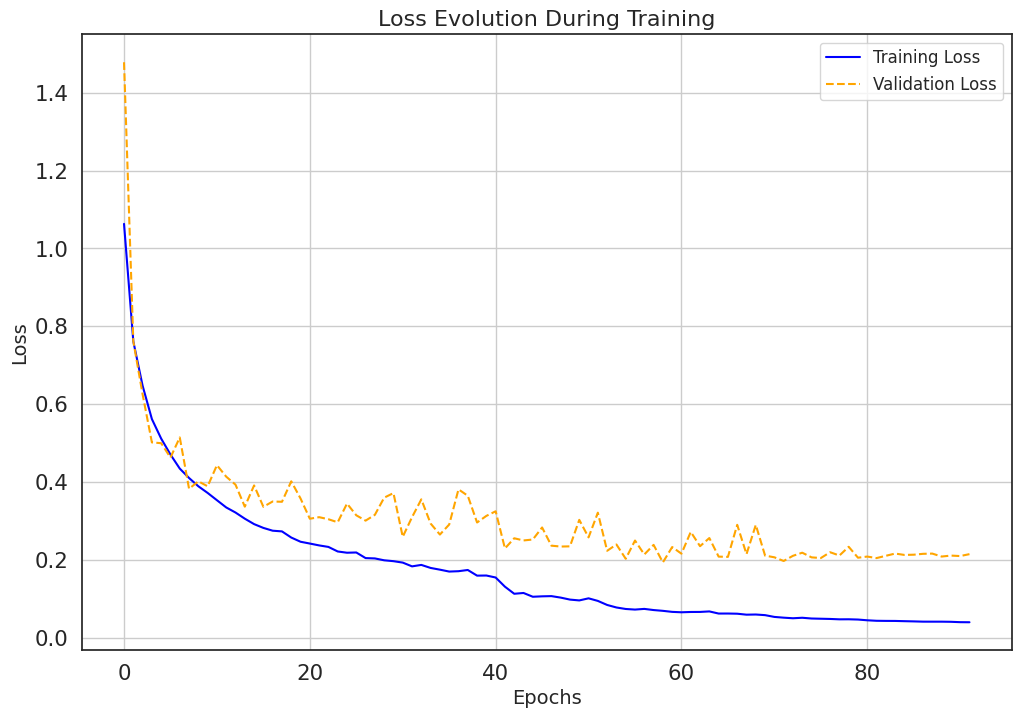

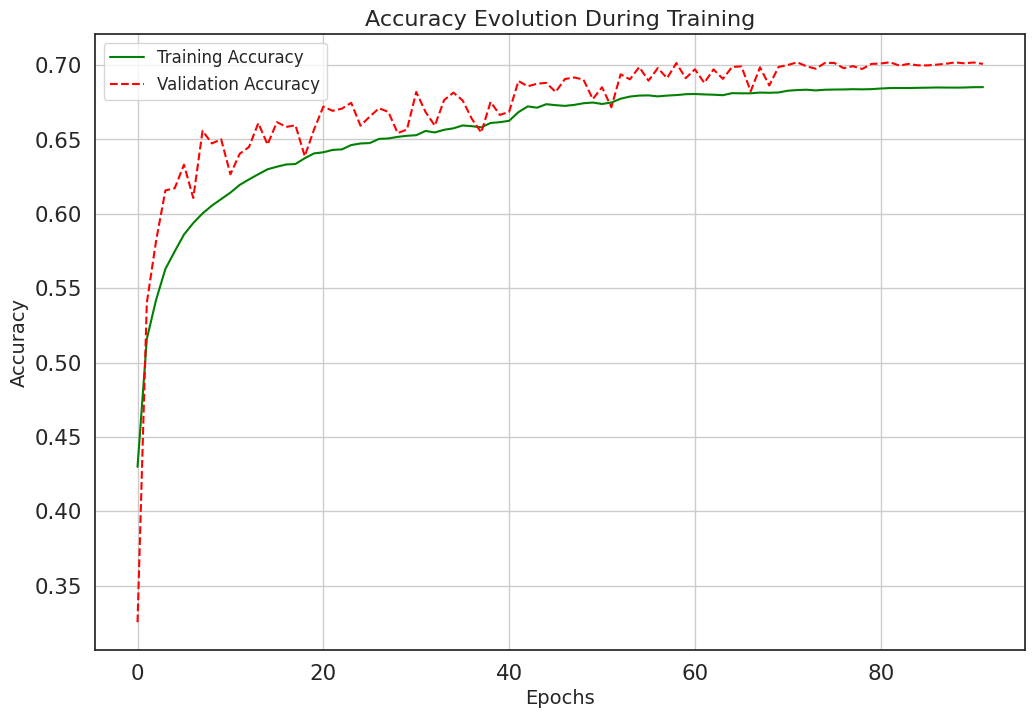

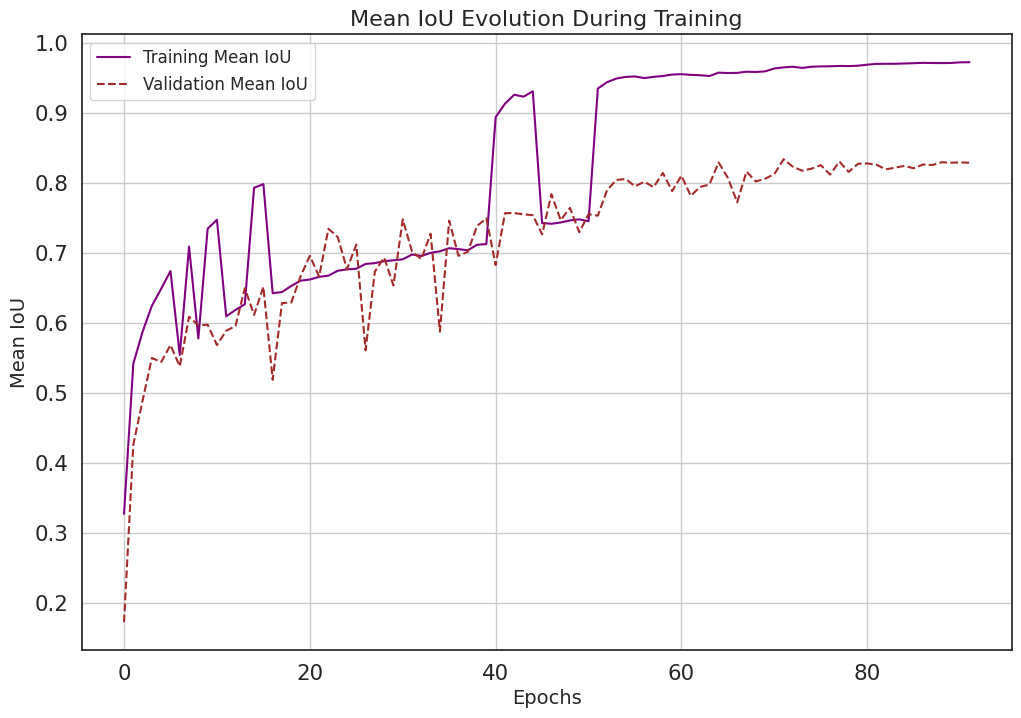

In [18]:
import matplotlib.pyplot as plt

# Extract values from history
epochs = range(len(history['loss']))

# Plot Training and Validation Loss 
plt.figure(figsize=(12, 8))
plt.plot(epochs, history['loss'], label='Training Loss', color='blue', linestyle='-')
plt.plot(epochs, history['val_loss'], label='Validation Loss', color='orange', linestyle='--')
plt.title('Loss Evolution During Training', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True) 
plt.show()

# Plot Training and Validation Accuracy
if 'accuracy' in history and 'val_accuracy' in history:
    plt.figure(figsize=(12, 8))
    plt.plot(epochs, history['accuracy'], label='Training Accuracy', color='green', linestyle='-')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy', color='red', linestyle='--')
    plt.title('Accuracy Evolution During Training', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

# Plot Training and Validation Mean IoU
if 'mean_iou' in history and 'val_mean_iou' in history:
    plt.figure(figsize=(12, 8))
    plt.plot(epochs, history['mean_iou'], label='Training Mean IoU', color='purple', linestyle='-')
    plt.plot(epochs, history['val_mean_iou'], label='Validation Mean IoU', color='brown', linestyle='--')
    plt.title('Mean IoU Evolution During Training', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Mean IoU', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

In [19]:
model = tfk.models.load_model(f'/kaggle/working/UNet_83.43.keras', compile=False)


In [20]:
# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(ignore_class = 0),
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])]
)

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
print("Model compiled!")



Model compiled!


In [21]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step
Predictions shape: (10022, 64, 128)


In [22]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [23]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)


In [44]:
del model